# [Unit 16 附錄B] Cats vs Dogs 遷移學習實戰

**課程名稱**：化工資料科學與機器學習實務（CHE-AI-101）  
**教材定位**：選讀附錄，建議在 Unit17（NEU 鋼材缺陷）前閱讀

**本附錄目標**：
1.  **遷移學習 (Transfer Learning)**：學習如何站在巨人的肩膀上，利用預訓練模型 (Pre-trained Model) 解決小數據問題。
2.  **資料管線 (Data Pipeline)**：使用 `tf.keras.utils.image_dataset_from_directory` 從資料夾結構自動載入影像。
3.  **模型微調 (Fine-tuning)**：凍結預訓練權重，只訓練最後的分類層。
4.  **信心度解讀**：理解模型輸出的機率值 (Confidence Score) 在工業檢測中的意義。

**化工應用類比**：
-   **產品外觀瑕疵檢測**：利用在 ImageNet 上訓練好的強大特徵提取能力，快速適應工廠內特定的瑕疵類型（如刮痕、氣泡）。
-   **顯微影像分析**：辨識特定的晶體結構或微生物形態。

**學習路徑**：
- **附錄A (MNIST)**: CNN 基礎概念 → **本附錄 (Cats vs Dogs)**: 遷移學習 → **Unit17 (NEU)**: 工業應用

---
## 📋 環境設定說明

本 notebook 採用 Part_4 本地化路徑設計：
- **資料集**: `Part_4/data/cats_and_dogs_filtered/`
- **輸出**: `Part_4/outputs/P4_Unit16_CatsVsDogs_Results/`

**執行前準備**：
請參考 [DATA_PREPARATION.md](DATA_PREPARATION.md) 準備 Cats vs Dogs 資料集。

In [4]:

# 過濾常見的無害警告
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', message='.*TFLite.*')

# ========================================
# Part_4 本地化路徑設定
# ========================================
from pathlib import Path
import os
import tensorflow as tf

# 使用 Part_4 本地資料夾（完全自包含，不依賴全域 Jupyter_Scripts）
NOTEBOOK_DIR = Path.cwd()
DATA_DIR = NOTEBOOK_DIR / 'data'
OUTPUT_DIR = NOTEBOOK_DIR / 'outputs' / 'P4_Unit16_CatsVsDogs_Results'

# 創建必要目錄
DATA_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print("="*60)
print("Part_4 Unit16 附錄B: Cats vs Dogs 遷移學習實戰")
print("="*60)
print(f"\n✓ Notebook 目錄: {NOTEBOOK_DIR}")
print(f"✓ 資料目錄: {DATA_DIR}")
print(f"✓ 輸出目錄: {OUTPUT_DIR}")

# ========================================
# 資料集路徑設定
# ========================================
cats_dogs_data_dir = DATA_DIR / 'cats_and_dogs_filtered'

# ========================================
# TensorFlow 與 GPU 設定
# ========================================
print(f"\n{'='*60}")
print("TensorFlow 環境檢查")
print(f"{'='*60}")
print(f"TensorFlow 版本: {tf.__version__}")

# 檢查 GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✓ GPU 可用: {gpus[0].name}")
    # 啟用記憶體增長，避免 OOM
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✓ GPU 記憶體動態配置已啟用")
    except:
        pass
else:
    print("△ 未偵測到 GPU，將使用 CPU (訓練速度較慢)")

# 視覺化設定
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.unicode_minus"] = False

# 設定中文字體,避免顯示警告
try:
    plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei', 'DejaVu Sans']
    plt.rcParams['axes.unicode_minus'] = False
except:
    pass  # 若字體不可用,使用預設

print(f"\n{'='*60}")
print("✓ 環境設定完成！")
print(f"{'='*60}")

Part_4 Unit16 附錄B: Cats vs Dogs 遷移學習實戰

✓ Notebook 目錄: g:\我的雲端硬碟\FCU\課程\ChemEng_AI_Course_Materials\Part_4
✓ 資料目錄: g:\我的雲端硬碟\FCU\課程\ChemEng_AI_Course_Materials\Part_4\data
✓ 輸出目錄: g:\我的雲端硬碟\FCU\課程\ChemEng_AI_Course_Materials\Part_4\outputs\P4_Unit16_CatsVsDogs_Results

TensorFlow 環境檢查
TensorFlow 版本: 2.10.0
✓ GPU 可用: /physical_device:GPU:0
✓ GPU 記憶體動態配置已啟用

✓ 環境設定完成！


---
## 1. 資料下載與資料管線建立 (Data Pipeline)

我們使用 Google 提供的縮減版 **Cats vs Dogs** 資料集。
這個資料集已經幫我們分好了 `train` 與 `validation` 資料夾。

我們將使用 `image_dataset_from_directory` 來建立高效的資料管線：
-   自動讀取圖片
-   解碼 (Decode)
-   調整大小 (Resize)
-   分批 (Batch)

In [5]:
# ========================================
# 資料集自動下載與載入
# ========================================
import zipfile
import requests
from tqdm import tqdm

# 檢查資料集是否已存在
if not cats_dogs_data_dir.exists():
    print("=" * 60)
    print("📥 資料集不存在，開始自動下載...")
    print("=" * 60)
    
    # 定義主要與備用下載連結
    urls = [
        "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip",
        "https://storage.googleapis.com/tensorflow-1-public/course2/cats_and_dogs_filtered.zip" 
    ]
    zip_filename = DATA_DIR / "cats_and_dogs_filtered.zip"
    
    def download_file(url, filename):
        """下載檔案並顯示進度條"""
        print(f"\n嘗試從以下網址下載: {url}")
        headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64)'}
        try:
            response = requests.get(url, headers=headers, stream=True, timeout=30)
            response.raise_for_status()
            
            # 獲取檔案大小
            total_size = int(response.headers.get('content-length', 0))
            
            # 使用進度條下載
            with open(filename, 'wb') as f:
                if total_size > 0:
                    with tqdm(total=total_size, unit='B', unit_scale=True, desc="下載中") as pbar:
                        for chunk in response.iter_content(chunk_size=8192):
                            f.write(chunk)
                            pbar.update(len(chunk))
                else:
                    for chunk in response.iter_content(chunk_size=8192):
                        f.write(chunk)
            
            # 驗證下載的是否為有效的 Zip 檔
            if not zipfile.is_zipfile(filename):
                print("⚠ 下載的檔案不是有效的 Zip 檔")
                return False
            
            print("✓ 下載完成！")
            return True
            
        except Exception as e:
            print(f"✗ 下載失敗: {e}")
            return False
    
    # 嘗試從多個來源下載
    download_success = False
    for url in urls:
        if download_file(url, zip_filename):
            download_success = True
            break
    
    if not download_success:
        print("\n" + "="*60)
        print("⚠ 自動下載失敗！請手動下載資料集")
        print("="*60)
        print("\n請執行以下步驟:")
        print("   1. 下載資料集：")
        print("      https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip")
        print(f"   2. 解壓縮到：{DATA_DIR}/")
        print(f"   3. 確認資料夾結構：{cats_dogs_data_dir}/train/ 和 .../validation/")
        print("\n或嘗試備用連結：")
        print("      https://storage.googleapis.com/tensorflow-1-public/course2/cats_and_dogs_filtered.zip")
        print("="*60)
        raise FileNotFoundError(f"無法下載資料集，請手動準備")
    
    # 解壓縮檔案
    print("\n📦 解壓縮資料集...")
    try:
        with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
            # 顯示解壓縮進度
            members = zip_ref.namelist()
            with tqdm(total=len(members), desc="解壓縮中") as pbar:
                for member in members:
                    zip_ref.extract(member, DATA_DIR)
                    pbar.update(1)
        
        print("✓ 解壓縮完成！")
        
        # 刪除 zip 檔案以節省空間
        zip_filename.unlink()
        print("✓ 已清理暫存檔案")
        
    except zipfile.BadZipFile:
        print("✗ Zip 檔案損毀，請重新下載")
        if zip_filename.exists():
            zip_filename.unlink()
        raise
    
    # 驗證資料集結構
    if not cats_dogs_data_dir.exists():
        raise FileNotFoundError(f"解壓縮後找不到資料集目錄: {cats_dogs_data_dir}")
    
    print("=" * 60)

else:
    print("=" * 60)
    print(f"✓ 資料集已存在: {cats_dogs_data_dir}")
    print("=" * 60)

# ========================================
# 建立資料管線 (Data Pipeline)
# ========================================
train_dir = cats_dogs_data_dir / "train"
validation_dir = cats_dogs_data_dir / "validation"

print(f"\n訓練資料路徑: {train_dir}")
print(f"驗證資料路徑: {validation_dir}")

# 設定參數
batch_size = 32
img_size = (160, 160)  # MobileNetV2 建議輸入大小

# 建立訓練資料集
print("\n建立訓練集 (Training Set)...")
train_dataset = tf.keras.utils.image_dataset_from_directory(
    str(train_dir),
    shuffle=True,
    batch_size=batch_size,
    image_size=img_size,
)

# 保存類別名稱 (因為經過 prefetch 後屬性會消失)
class_names = train_dataset.class_names
print(f"類別: {class_names}")

# 建立驗證資料集
print("\n建立驗證集 (Validation Set)...")
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    str(validation_dir),
    shuffle=True,
    batch_size=batch_size,
    image_size=img_size,
)

# Prefetching 加速資料讀取 (讓 CPU 準備下一批資料時，GPU 不用閒置)
autotune = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=autotune)
validation_dataset = validation_dataset.prefetch(buffer_size=autotune)

print(f"\n✓ 資料管線建立完成！")
print(f"  - 訓練批次數: {len(train_dataset)}")
print(f"  - 驗證批次數: {len(validation_dataset)}")
print(f"  - 批次大小: {batch_size}")
print(f"  - 影像尺寸: {img_size}")
print("=" * 60)


✓ 資料集已存在: g:\我的雲端硬碟\FCU\課程\ChemEng_AI_Course_Materials\Part_4\data\cats_and_dogs_filtered

訓練資料路徑: g:\我的雲端硬碟\FCU\課程\ChemEng_AI_Course_Materials\Part_4\data\cats_and_dogs_filtered\train
驗證資料路徑: g:\我的雲端硬碟\FCU\課程\ChemEng_AI_Course_Materials\Part_4\data\cats_and_dogs_filtered\validation

建立訓練集 (Training Set)...
Found 2000 files belonging to 2 classes.
類別: ['cats', 'dogs']

建立驗證集 (Validation Set)...
Found 1000 files belonging to 2 classes.

✓ 資料管線建立完成！
  - 訓練批次數: 63
  - 驗證批次數: 32
  - 批次大小: 32
  - 影像尺寸: (160, 160)


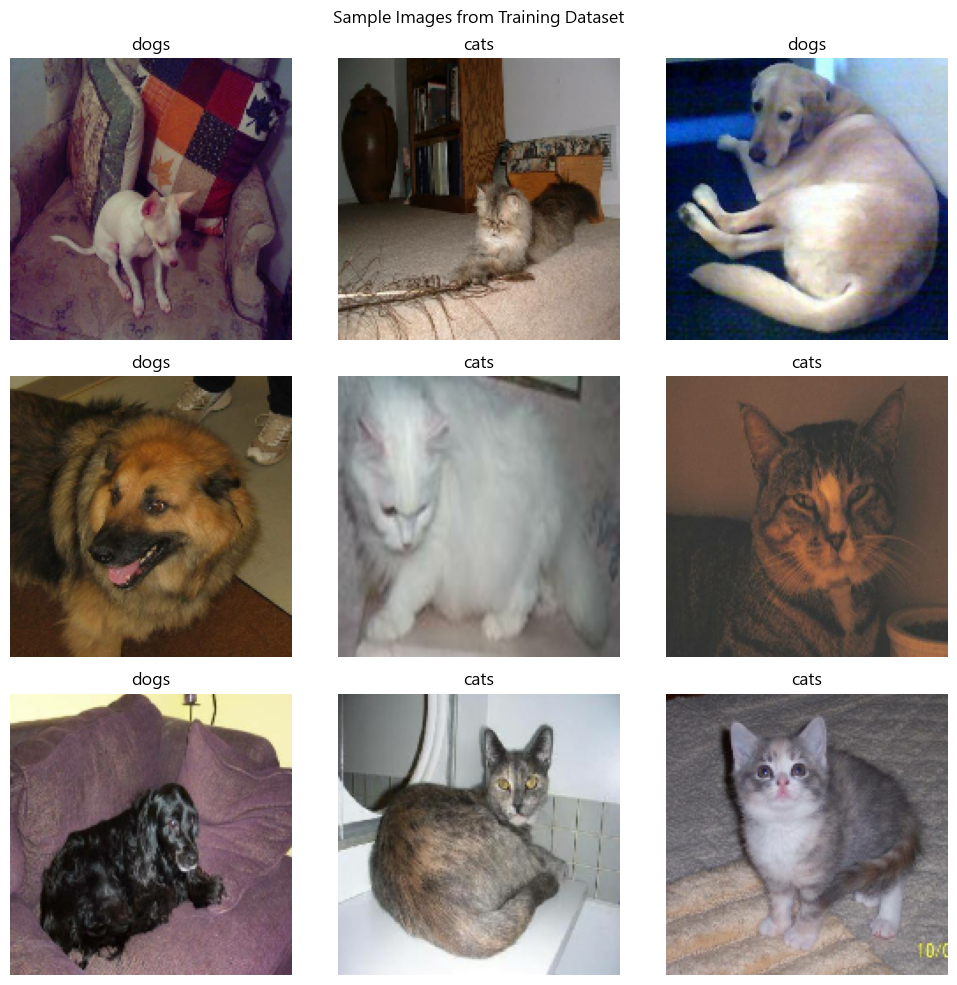

In [7]:
# 視覺化部分訓練樣本
# class_names = train_dataset.class_names  # 已在上方 Cell 定義，避免 PrefetchDataset 錯誤

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype(np.uint8))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.suptitle("Sample Images from Training Dataset")
plt.tight_layout()
plt.savefig(str(OUTPUT_DIR / 'sample_images.png'))
plt.show()

---
## 2. 建立遷移學習模型 (Build Transfer Model)

我們將使用 **MobileNetV2** 作為我們的基礎模型 (Base Model)。
MobileNetV2 是一個輕量級且高效的 CNN，已經在 ImageNet (1400 萬張圖片，1000 類) 上訓練過。

**策略**：
1.  **載入預訓練模型**：去掉頂層的分類器 (`include_top=False`)。
2.  **凍結權重 (Freeze)**：設定 `trainable = False`，保護預訓練好的特徵提取能力不被破壞。
3.  **加入自訂分類頭**：接上 `GlobalAveragePooling2D` 與 `Dense` 層來處理我們的貓狗二分類任務。

In [9]:
from tensorflow.keras import layers

img_shape = (160, 160, 3)

# 預訓練模型：不含原本 ImageNet 的分類頭
base_model = tf.keras.applications.MobileNetV2(
    input_shape=img_shape,
    include_top=False,
    weights="imagenet",
)

# 凍結 base_model 權重，不在本次訓練中更新
base_model.trainable = False
print("✓ Base Model (MobileNetV2) 已載入並凍結權重。")

# 建立完整模型
model = tf.keras.Sequential(
    [
        layers.InputLayer(input_shape=img_shape),
        # 將 [0, 255] 的輸入縮放到 [-1, 1] (MobileNetV2 的要求)
        layers.Rescaling(1.0 / 127.5, offset=-1.0),
        base_model,
        layers.GlobalAveragePooling2D(), # 將特徵圖壓縮為向量
        layers.Dropout(0.2),            # 防止過擬合
        layers.Dense(1, activation="sigmoid"), # 二元分類輸出 (0~1 機率)
    ]
)

# 編譯模型
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

model.summary()

✓ Base Model (MobileNetV2) 已載入並凍結權重。
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 160, 160, 3)       0         
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2,259

---
## 3. 訓練模型 (Training)

由於 Base Model 已經學會了如何「看」圖片（邊緣、紋理、形狀），我們只需要訓練最後的分類層。
這通常只需要很少的 Epochs 就能達到很高的準確率。

In [10]:
epochs = 10
print(f"開始訓練 {epochs} 個 epochs...")

history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=validation_dataset,
)
print("訓練完成！")

開始訓練 10 個 epochs...
Epoch 1/10
63/63 [==============================] - 13s 148ms/step - loss: 0.5373 - accuracy: 0.7420 - val_loss: 0.4048 - val_accuracy: 0.8760
Epoch 2/10
63/63 [==============================] - 10s 139ms/step - loss: 0.3679 - accuracy: 0.8695 - val_loss: 0.2894 - val_accuracy: 0.9260
Epoch 3/10
63/63 [==============================] - 10s 138ms/step - loss: 0.2791 - accuracy: 0.9150 - val_loss: 0.2240 - val_accuracy: 0.9370
Epoch 4/10
63/63 [==============================] - 10s 138ms/step - loss: 0.2200 - accuracy: 0.9385 - val_loss: 0.1834 - val_accuracy: 0.9510
Epoch 5/10
63/63 [==============================] - 10s 137ms/step - loss: 0.1862 - accuracy: 0.9565 - val_loss: 0.1569 - val_accuracy: 0.9620
Epoch 6/10
63/63 [==============================] - 10s 139ms/step - loss: 0.1572 - accuracy: 0.9660 - val_loss: 0.1384 - val_accuracy: 0.9640
Epoch 7/10
63/63 [==============================] - 10s 140ms/step - loss: 0.1470 - accuracy: 0.9610 - val_loss: 0.1242 - 

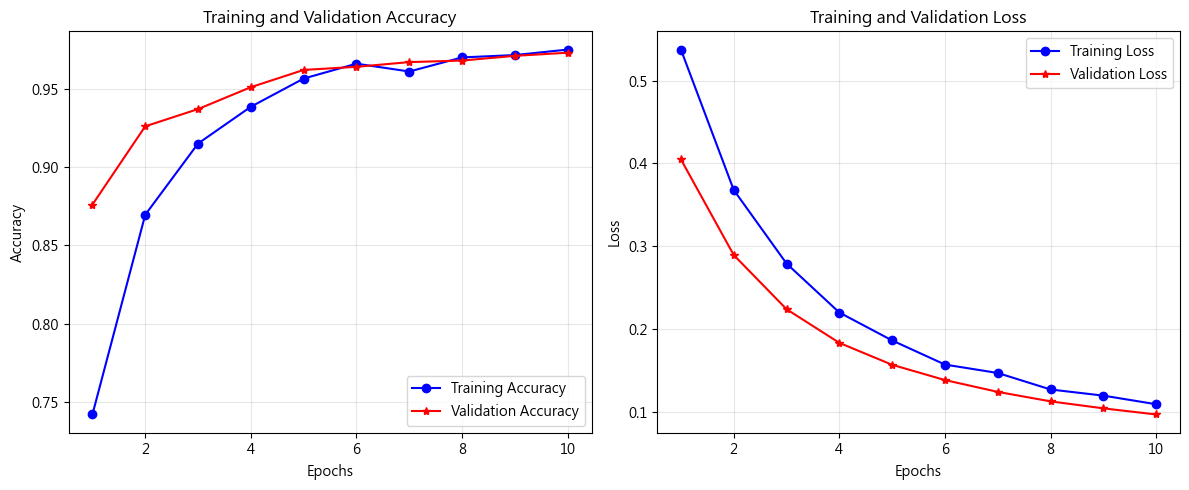

In [12]:
# 繪製學習曲線
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epoch_range = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(epoch_range, acc, "bo-", label="Training Accuracy")
plt.plot(epoch_range, val_acc, "r*-", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True, alpha=0.3)

# Loss
plt.subplot(1, 2, 2)
plt.plot(epoch_range, loss, "bo-", label="Training Loss")
plt.plot(epoch_range, val_loss, "r*-", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(str(OUTPUT_DIR / 'learning_curves.png'))
plt.show()

---
## 4. 預測結果與信心度展示 (Predictions)

我們從驗證集中取出一批圖片進行預測，並觀察模型的 **信心度 (Confidence Score)**。
-   輸出值 > 0.5 判斷為 **Dog**。
-   輸出值 < 0.5 判斷為 **Cat**。
-   數值越接近 0 或 1，代表模型越有把握；越接近 0.5 代表越猶豫。

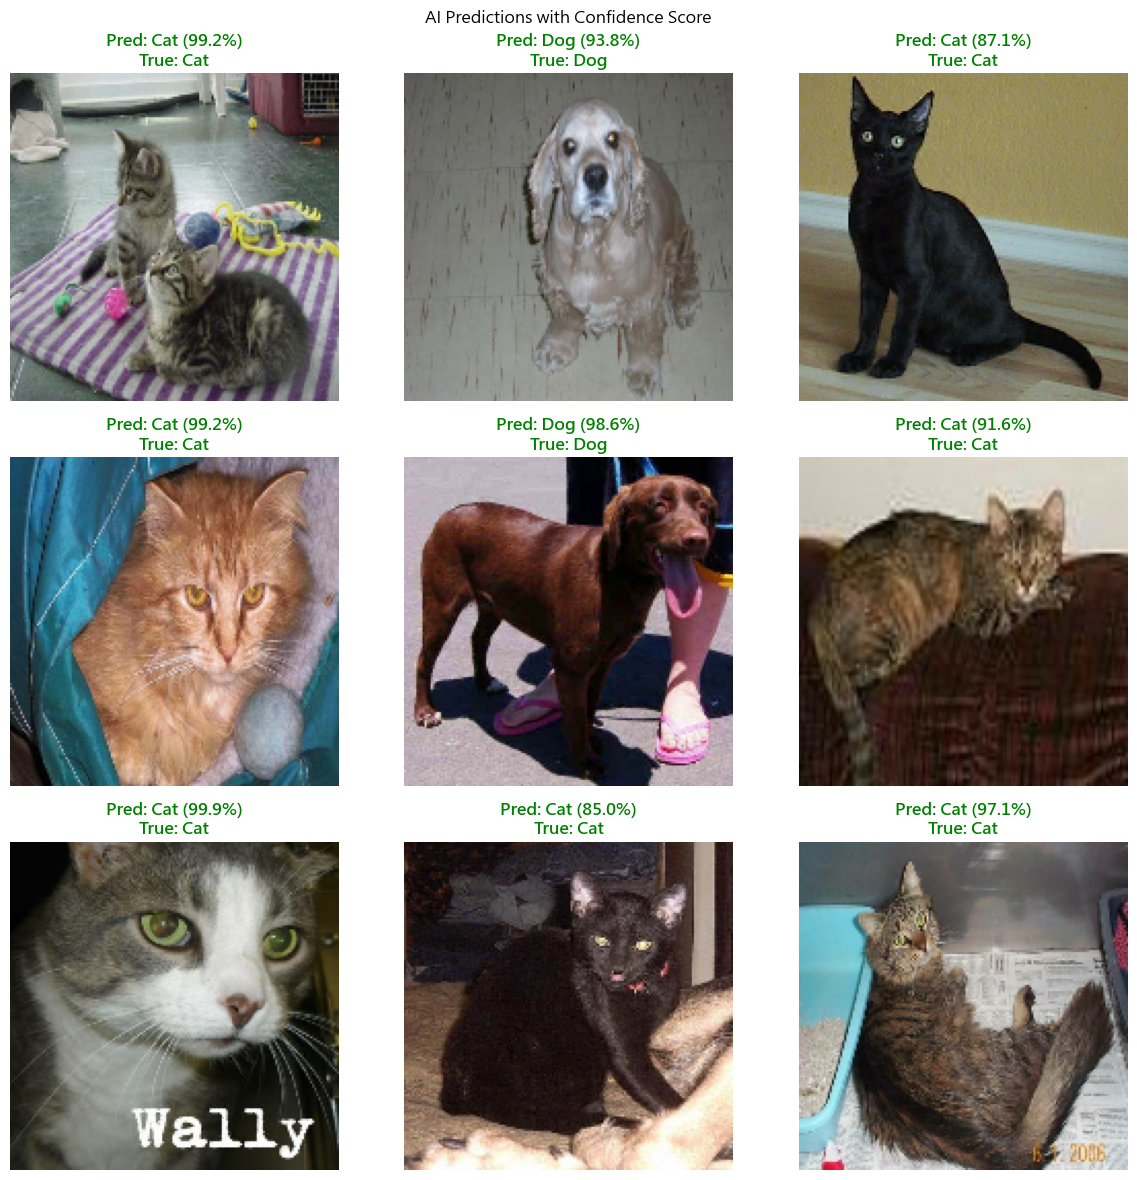

模型已儲存至 P4_Unit16_CatsVsDogs_Results/transfer_learning_model.h5


In [15]:
# 取出一批次資料
image_batch, label_batch = next(iter(validation_dataset))
predictions = model.predict(image_batch, verbose=0)

num_samples = 9
plt.figure(figsize=(12, 12))

for i in range(num_samples):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype(np.uint8))

    score = float(predictions[i][0])
    # Sigmoid 輸出：接近 1 是 Dog，接近 0 是 Cat
    if score > 0.5:
        pred_label = "Dog"
        confidence = score * 100.0
    else:
        pred_label = "Cat"
        confidence = (1.0 - score) * 100.0

    true_label = "Dog" if int(label_batch[i]) == 1 else "Cat"
    
    # 預測正確顯示綠色，錯誤顯示紅色
    color = "green" if pred_label == true_label else "red"

    plt.title(
        f"Pred: {pred_label} ({confidence:.1f}%)\nTrue: {true_label}",
        color=color,
        fontsize=12,
        fontweight='bold'
    )
    plt.axis("off")

plt.suptitle("AI Predictions with Confidence Score")
plt.tight_layout()
plt.savefig(str(OUTPUT_DIR / 'predictions.png'))
plt.show()

# 儲存模型
# 儲存為 .h5 格式 (Keras 傳統格式)
model.save(str(OUTPUT_DIR / 'transfer_learning_model.h5'))
print("模型已儲存至 P4_Unit16_CatsVsDogs_Results/transfer_learning_model.h5")

---
## 5. 化工品質檢測:性能指標深度分析

在化工產業中,不同類型的錯誤有不同的成本:
-   **False Negative (漏檢)**: 瑕疵品流入市場 → 召回成本、商譽損失
-   **False Positive (誤殺)**: 良品被丟棄 → 直接經濟損失

我們需要計算**混淆矩陣 (Confusion Matrix)** 與關鍵指標。

正在對驗證集進行完整預測...


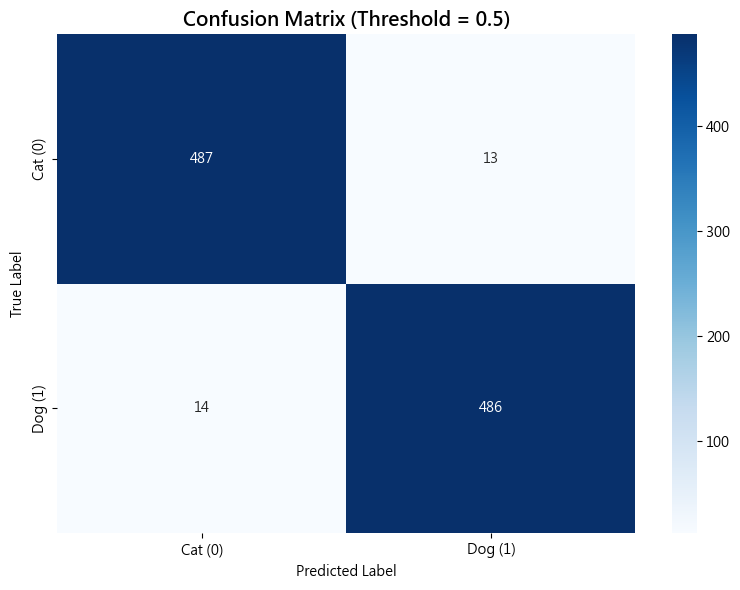


混淆矩陣分析 (Confusion Matrix Analysis)
True Negatives (TN):   487 | 正確判定為 Cat
False Positives (FP):   13 | Cat 被誤判為 Dog (誤殺)
False Negatives (FN):   14 | Dog 被誤判為 Cat (漏檢)
True Positives (TP):   486 | 正確判定為 Dog

關鍵性能指標:
  準確率 (Accuracy):   0.9730
  精確率 (Precision):  0.9739 | 預測為Dog中,真Dog的比例
  召回率 (Recall):     0.9720 | 所有Dog中,被成功識別的比例
  F1-Score:            0.9730 | Precision 與 Recall 的調和平均
  特異性 (Specificity): 0.9740 | 所有Cat中,被正確識別的比例

【化工品質檢測應用解讀】
若將 'Dog' 視為瑕疵品,'Cat' 視為良品:
  • 漏檢率 = 14/500 = 2.80% (有 2.80% 的瑕疵品會流入市場)
  • 誤殺率 = 13/500 = 2.60% (有 2.60% 的良品會被丟棄)

在半導體產業,若單片晶圓成本 $3000,召回成本 $50000:
  • 每次漏檢損失: $50,000
  • 每次誤殺損失: $3,000
  • 成本比 (FN:FP) = 17:1
  → 建議策略: 降低閾值,提高召回率,允許較高誤殺率


In [18]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns

# 對整個驗證集進行預測
print("正在對驗證集進行完整預測...")
y_true = []
y_pred_probs = []

for images, labels in validation_dataset:
    predictions = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred_probs.extend(predictions[:, 0])

y_true = np.array(y_true)
y_pred_probs = np.array(y_pred_probs)
y_pred = (y_pred_probs > 0.5).astype(np.int32)  # 預設閾值 0.5

# 計算混淆矩陣
cm = confusion_matrix(y_true, y_pred)

# 視覺化
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Cat (0)', 'Dog (1)'], 
            yticklabels=['Cat (0)', 'Dog (1)'])
plt.title('Confusion Matrix (Threshold = 0.5)', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig(str(OUTPUT_DIR / 'confusion_matrix.png'), dpi=150)
plt.show()

# 提取混淆矩陣元素
tn, fp, fn, tp = cm.ravel()

print("\n" + "="*50)
print("混淆矩陣分析 (Confusion Matrix Analysis)")
print("="*50)
print(f"True Negatives (TN):  {tn:4d} | 正確判定為 Cat")
print(f"False Positives (FP): {fp:4d} | Cat 被誤判為 Dog (誤殺)")
print(f"False Negatives (FN): {fn:4d} | Dog 被誤判為 Cat (漏檢)")
print(f"True Positives (TP):  {tp:4d} | 正確判定為 Dog")
print("="*50)

# 計算關鍵指標
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

print("\n關鍵性能指標:")
print(f"  準確率 (Accuracy):   {accuracy:.4f}")
print(f"  精確率 (Precision):  {precision:.4f} | 預測為Dog中,真Dog的比例")
print(f"  召回率 (Recall):     {recall:.4f} | 所有Dog中,被成功識別的比例")
print(f"  F1-Score:            {f1_score:.4f} | Precision 與 Recall 的調和平均")
print(f"  特異性 (Specificity): {specificity:.4f} | 所有Cat中,被正確識別的比例")
print("="*50)

# 化工應用解讀
print("\n【化工品質檢測應用解讀】")
print(f"若將 'Dog' 視為瑕疵品,'Cat' 視為良品:")
print(f"  • 漏檢率 = {fn}/{tp+fn} = {fn/(tp+fn)*100:.2f}% (有 {fn/(tp+fn)*100:.2f}% 的瑕疵品會流入市場)")
print(f"  • 誤殺率 = {fp}/{tn+fp} = {fp/(tn+fp)*100:.2f}% (有 {fp/(tn+fp)*100:.2f}% 的良品會被丟棄)")
print(f"\n在半導體產業,若單片晶圓成本 $3000,召回成本 $50000:")
print(f"  • 每次漏檢損失: $50,000")
print(f"  • 每次誤殺損失: $3,000")
print(f"  • 成本比 (FN:FP) = 17:1")
print(f"  → 建議策略: 降低閾值,提高召回率,允許較高誤殺率")

---
## 6. ROC 曲線與最佳閾值選擇

**ROC (Receiver Operating Characteristic) 曲線** 可以幫助我們:
1.  評估模型在不同閾值下的表現
2.  根據化工檢測需求,選擇最佳閾值
3.  計算 AUC (Area Under Curve) 作為模型整體性能指標

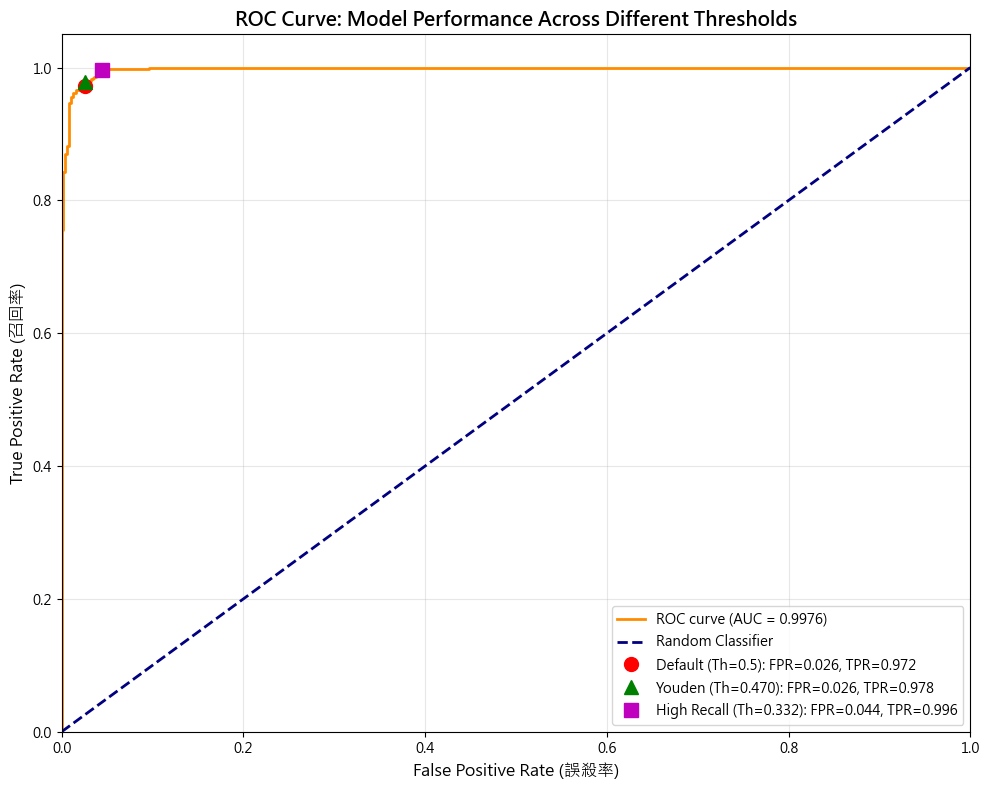


閾值策略比較 (Threshold Strategy Comparison)
策略                   閾值       TPR(召回率)     FPR(誤殺率)     適用場景                
----------------------------------------------------------------------
Default (0.5)        0.500    0.972        0.026        一般應用
Youden Index         0.470    0.978        0.026        平衡 Precision/Recall
High Recall (≥99%)   0.332    0.996        0.044        高風險產品(藥品)

【化工成本最佳化閾值計算】
假設成本: FN = $50000, FP = $3000
理論最佳閾值 = 1 / (1 + C_FP/C_FN) = 1 / (1 + 0.0600) = 0.9434

實務建議: 使用閾值 0.94 可最小化總成本
此時 TPR ≈ 0.756, FPR ≈ 0.000


In [21]:
# 計算 ROC 曲線
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)

# 繪製 ROC 曲線
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')

# 標記三個策略點
# 1. 預設閾值 0.5
idx_default = np.argmin(np.abs(thresholds - 0.5))
plt.plot(fpr[idx_default], tpr[idx_default], 'ro', markersize=10, 
         label=f'Default (Th=0.5): FPR={fpr[idx_default]:.3f}, TPR={tpr[idx_default]:.3f}')

# 2. Youden Index (最大化 TPR - FPR)
youden_index = tpr - fpr
idx_youden = np.argmax(youden_index)
plt.plot(fpr[idx_youden], tpr[idx_youden], 'g^', markersize=10,
         label=f'Youden (Th={thresholds[idx_youden]:.3f}): FPR={fpr[idx_youden]:.3f}, TPR={tpr[idx_youden]:.3f}')

# 3. 高召回策略 (TPR > 0.99)
idx_high_recall = np.where(tpr >= 0.99)[0]
if len(idx_high_recall) > 0:
    idx_hr = idx_high_recall[0]
    plt.plot(fpr[idx_hr], tpr[idx_hr], 'ms', markersize=10,
             label=f'High Recall (Th={thresholds[idx_hr]:.3f}): FPR={fpr[idx_hr]:.3f}, TPR={tpr[idx_hr]:.3f}')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (誤殺率)', fontsize=12)
plt.ylabel('True Positive Rate (召回率)', fontsize=12)
plt.title('ROC Curve: Model Performance Across Different Thresholds', fontsize=14, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(str(OUTPUT_DIR / 'roc_curve.png'), dpi=150)
plt.show()

print("\n" + "="*70)
print("閾值策略比較 (Threshold Strategy Comparison)")
print("="*70)
print(f"{'策略':<20} {'閾值':<8} {'TPR(召回率)':<12} {'FPR(誤殺率)':<12} {'適用場景':<20}")
print("-"*70)
print(f"{'Default (0.5)':<20} {0.5:<8.3f} {tpr[idx_default]:<12.3f} {fpr[idx_default]:<12.3f} {'一般應用'}")
print(f"{'Youden Index':<20} {thresholds[idx_youden]:<8.3f} {tpr[idx_youden]:<12.3f} {fpr[idx_youden]:<12.3f} {'平衡 Precision/Recall'}")
if len(idx_high_recall) > 0:
    print(f"{'High Recall (≥99%)':<20} {thresholds[idx_hr]:<8.3f} {tpr[idx_hr]:<12.3f} {fpr[idx_hr]:<12.3f} {'高風險產品(藥品)'}")
print("="*70)

# 成本最佳化閾值
print("\n【化工成本最佳化閾值計算】")
cost_fn = 50000  # 漏檢成本 (瑕疵流入市場)
cost_fp = 3000   # 誤殺成本 (丟棄良品)
cost_ratio = cost_fp / cost_fn
optimal_threshold_formula = 1 / (1 + cost_ratio)

print(f"假設成本: FN = ${cost_fn}, FP = ${cost_fp}")
print(f"理論最佳閾值 = 1 / (1 + C_FP/C_FN) = 1 / (1 + {cost_ratio:.4f}) = {optimal_threshold_formula:.4f}")
print(f"\n實務建議: 使用閾值 {optimal_threshold_formula:.2f} 可最小化總成本")
print(f"此時 TPR ≈ {tpr[np.argmin(np.abs(thresholds - optimal_threshold_formula))]:.3f}, FPR ≈ {fpr[np.argmin(np.abs(thresholds - optimal_threshold_formula))]:.3f}")

---
## 7. 化工品質檢測決策系統實作

基於前面的分析,我們設計一個 **三級決策系統** 來模擬實際化工產線的品質管制流程。

化工品質檢測三級決策系統演示
信心度: 0.98 → [AUTO_REJECT    ] 自動廢棄 (瑕疵品)
信心度: 0.05 → [UNKNOWN        ] ⚠ 未知類型,停線通知工程師
信心度: 0.72 → [HUMAN_REVIEW   ] 可疑瑕疵,送人工審查
信心度: 0.35 → [UNKNOWN        ] ⚠ 未知類型,停線通知工程師
信心度: 0.88 → [HUMAN_REVIEW   ] 可疑瑕疵,送人工審查
信心度: 0.50 → [UNKNOWN        ] ⚠ 未知類型,停線通知工程師


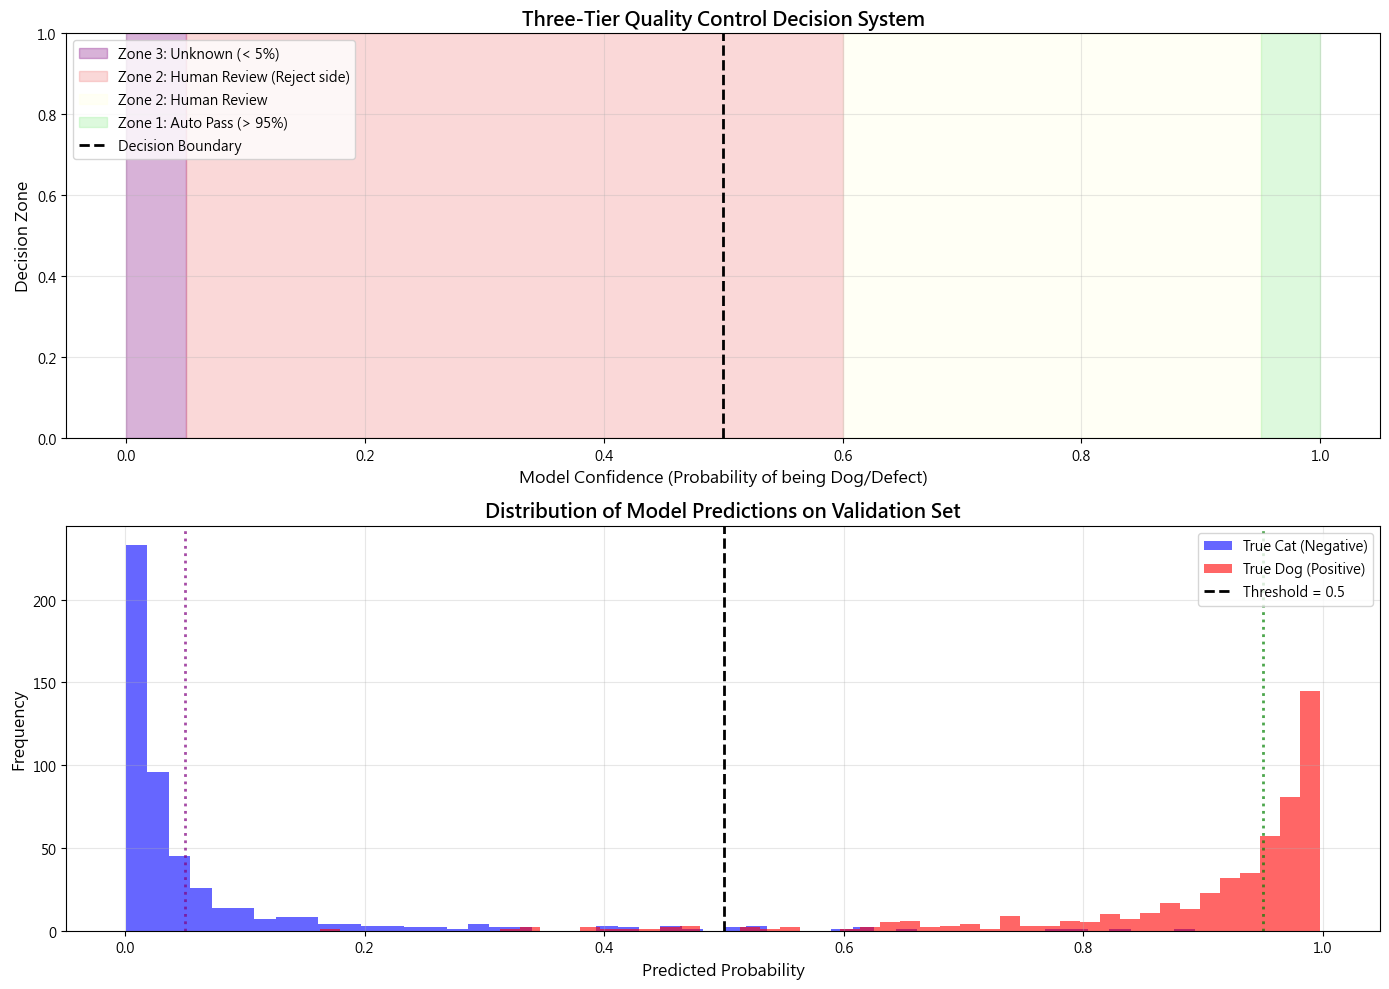


【驗證集決策分佈統計】
總樣本數: 1000
  • 自動放行 (高信心良品):      366 (36.60%)
  • 自動廢棄 (高信心瑕疵):      279 (27.90%)
  • 人工複檢 (中等信心):        339 (33.90%)
  • 未知類型 (極低信心):         16 ( 1.60%)

自動化率 (無需人工介入): 64.50%
人工複檢比例: 33.90%


In [24]:
def industrial_qc_decision(confidence, threshold_high=0.95, threshold_low=0.60):
    """
    化工品質管制三級決策系統
    
    Args:
        confidence: 模型信心度 (0-1)
        threshold_high: 高信心門檻,超過此值自動決策
        threshold_low: 低信心門檻,低於此值標記為未知
    
    Returns:
        decision: 決策類型
        action: 具體行動
        color: 顯示顏色
    """
    if confidence >= threshold_high:
        # Zone 1: 高信心區 - AI 自動決策
        if confidence >= 0.5:
            return 'AUTO_REJECT', '自動廢棄 (瑕疵品)', 'red'
        else:
            return 'AUTO_PASS', '自動放行 (良品)', 'green'
    
    elif confidence >= threshold_low:
        # Zone 2: 中等信心區 - 人工複檢
        if confidence >= 0.5:
            return 'HUMAN_REVIEW', '可疑瑕疵,送人工審查', 'orange'
        else:
            return 'HUMAN_REVIEW', '可疑良品,送人工審查', 'orange'
    
    else:
        # Zone 3: 低信心區 - 未知類型
        return 'UNKNOWN', '⚠ 未知類型,停線通知工程師', 'purple'

# 測試決策系統
print("="*70)
print("化工品質檢測三級決策系統演示")
print("="*70)

test_confidences = [0.98, 0.05, 0.72, 0.35, 0.88, 0.50]
for conf in test_confidences:
    decision, action, color = industrial_qc_decision(conf)
    print(f"信心度: {conf:.2f} → [{decision:15s}] {action}")

print("="*70)

# 視覺化決策區間
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# 子圖 1: 決策區間圖
x = np.linspace(0, 1, 1000)
ax1.axvspan(0, 0.05, alpha=0.3, color='purple', label='Zone 3: Unknown (< 5%)')
ax1.axvspan(0.05, 0.60, alpha=0.3, color='lightcoral', label='Zone 2: Human Review (Reject side)')
ax1.axvspan(0.60, 0.95, alpha=0.3, color='lightyellow', label='Zone 2: Human Review')
ax1.axvspan(0.95, 1.0, alpha=0.3, color='lightgreen', label='Zone 1: Auto Pass (> 95%)')
ax1.axvline(0.5, color='black', linestyle='--', linewidth=2, label='Decision Boundary')
ax1.set_xlabel('Model Confidence (Probability of being Dog/Defect)', fontsize=12)
ax1.set_ylabel('Decision Zone', fontsize=12)
ax1.set_title('Three-Tier Quality Control Decision System', fontsize=14, fontweight='bold')
ax1.set_ylim(0, 1)
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# 子圖 2: 實際驗證集分佈
ax2.hist(y_pred_probs[y_true == 0], bins=50, alpha=0.6, label='True Cat (Negative)', color='blue')
ax2.hist(y_pred_probs[y_true == 1], bins=50, alpha=0.6, label='True Dog (Positive)', color='red')
ax2.axvline(0.5, color='black', linestyle='--', linewidth=2, label='Threshold = 0.5')
ax2.axvline(0.05, color='purple', linestyle=':', linewidth=2, alpha=0.7)
ax2.axvline(0.95, color='green', linestyle=':', linewidth=2, alpha=0.7)
ax2.set_xlabel('Predicted Probability', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.set_title('Distribution of Model Predictions on Validation Set', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(str(OUTPUT_DIR / 'decision_system.png'), dpi=150)
plt.show()

# 統計各決策區間的樣本數
print("\n【驗證集決策分佈統計】")
auto_pass = np.sum((y_pred_probs < 0.5) & ((1 - y_pred_probs) > 0.95))
auto_reject = np.sum((y_pred_probs >= 0.5) & (y_pred_probs > 0.95))
human_review = np.sum((np.abs(y_pred_probs - 0.5) < 0.45) & (np.abs(y_pred_probs - 0.5) >= 0.05))
unknown = np.sum((np.abs(y_pred_probs - 0.5) < 0.05))

total = len(y_pred_probs)
print(f"總樣本數: {total}")
print(f"  • 自動放行 (高信心良品):     {auto_pass:4d} ({auto_pass/total*100:5.2f}%)")
print(f"  • 自動廢棄 (高信心瑕疵):     {auto_reject:4d} ({auto_reject/total*100:5.2f}%)")
print(f"  • 人工複檢 (中等信心):       {human_review:4d} ({human_review/total*100:5.2f}%)")
print(f"  • 未知類型 (極低信心):       {unknown:4d} ({unknown/total*100:5.2f}%)")
print(f"\n自動化率 (無需人工介入): {(auto_pass + auto_reject)/total*100:.2f}%")
print(f"人工複檢比例: {human_review/total*100:.2f}%")

---
## 8. 邊緣運算部署準備

化工產線通常需要**即時檢測**,我們可以將模型部署到邊緣設備 (Edge Device):
-   **NVIDIA Jetson Nano**: $99, 可達 30 FPS
-   **Raspberry Pi 4 + Coral TPU**: 更低成本方案
-   **工業級 PC**: 更高穩定性

關鍵步驟: **模型量化 (Quantization)** 以減小檔案大小與加速推論。

In [26]:
# 抑制 TFLite 轉換警告
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

# 轉換為 TensorFlow Lite 格式 (適用於邊緣設備)
import tensorflow as tf

# 建立 TFLite 轉換器
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# 啟用 INT8 量化 (8-bit 整數,大幅減小模型大小)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# 轉換模型
tflite_model = converter.convert()

# 儲存 TFLite 模型
tflite_path = str(OUTPUT_DIR / 'transfer_model_quantized.tflite')
with open(tflite_path, 'wb') as f:
    f.write(tflite_model)

# 比較檔案大小
h5_size = os.path.getsize(str(OUTPUT_DIR / 'transfer_learning_model.h5')) / (1024 * 1024)
tflite_size = os.path.getsize(tflite_path) / (1024 * 1024)

print("="*60)
print("模型檔案大小比較 (Model Size Comparison)")
print("="*60)
print(f"原始 Keras 模型 (.h5):     {h5_size:8.2f} MB")
print(f"TFLite 量化模型 (.tflite): {tflite_size:8.2f} MB")
print(f"壓縮比例:                 {(1 - tflite_size/h5_size)*100:8.2f}%")
print("="*60)

print("\n【邊緣部署建議】")
print("1. 硬體選擇:")
print("   • Jetson Nano (4GB):    ~$99,  推論速度 ~30 FPS")
print("   • Raspberry Pi 4 + Coral: ~$135, 推論速度 ~15 FPS")
print("   • 工業級 IPC + GPU:     ~$800+, 推論速度 >100 FPS")
print("\n2. 軟體架構:")
print("   • Python + TFLite Runtime (輕量級,不需完整 TensorFlow)")
print("   • C++ + TFLite API (最高性能,適合即時系統)")
print("\n3. 產線整合:")
print("   • MQTT/OPC-UA 協定與 SCADA 系統通訊")
print("   • 檢測結果寫入 SQL 資料庫供 MES 查詢")
print("   • 異常告警透過 Email/SMS/Line 通知")

print("\n✓ TFLite 模型已儲存至:", tflite_path)

模型檔案大小比較 (Model Size Comparison)
原始 Keras 模型 (.h5):         8.93 MB
TFLite 量化模型 (.tflite):     2.39 MB
壓縮比例:                    73.18%

【邊緣部署建議】
1. 硬體選擇:
   • Jetson Nano (4GB):    ~$99,  推論速度 ~30 FPS
   • Raspberry Pi 4 + Coral: ~$135, 推論速度 ~15 FPS
   • 工業級 IPC + GPU:     ~$800+, 推論速度 >100 FPS

2. 軟體架構:
   • Python + TFLite Runtime (輕量級,不需完整 TensorFlow)
   • C++ + TFLite API (最高性能,適合即時系統)

3. 產線整合:
   • MQTT/OPC-UA 協定與 SCADA 系統通訊
   • 檢測結果寫入 SQL 資料庫供 MES 查詢
   • 異常告警透過 Email/SMS/Line 通知

✓ TFLite 模型已儲存至: g:\我的雲端硬碟\FCU\課程\ChemEng_AI_Course_Materials\Part_4\outputs\P4_Unit16_CatsVsDogs_Results\transfer_model_quantized.tflite


---
## 9. 從 Cats vs Dogs 到工業影像檢測

### 9.1 經典案例與工業應用的對比

| 項目 | Cats vs Dogs | NEU 鋼材缺陷 (Unit17) | 化工製程差異 |
|------|-------------|---------------------|-------------|
| **資料集規模** | 3000 張 | 1800 張 | 工業資料稀缺 |
| **類別平衡** | 平衡 (1:1) | 平衡 (6類各300張) | 通常嚴重不平衡 |
| **背景複雜度** | 高（多樣場景） | 低（統一灰階） | 需控制拍攝條件 |
| **遷移學習效果** | 極佳 (ImageNet相似) | 良好 (需微調) | 依領域差距而定 |
| **部署環境** | 雲端 | 邊緣設備 (產線) | 需即時推論 |

### 9.2 工業瑕疵檢測資料集推薦

**1. NEU Surface Defect Database** ⭐ **Unit17 使用**
-   **URL**: http://faculty.neu.edu.cn/songkechen/zh_CN/zdylm/263270/list/index.htm
-   **內容**: 1,800 張熱軋鋼帶表面影像
-   **瑕疵類型**: 6 種 (氧化皮、斑點、裂紋、壓入氧化皮、凹坑、刮痕)
-   **特色**: 影像尺寸一致 (200x200),適合快速實驗
-   **化工關聯**: 冶金、材料科學

**2. MVTec Anomaly Detection (MVTec AD)** ⭐ 強烈推薦
-   **URL**: https://www.mvtec.com/company/research/datasets/mvtec-ad
-   **內容**: 15 種工業產品類別,5000+ 高解析度影像
-   **瑕疵類型**: 刮痕、凹陷、污染、裂紋、缺件等
-   **應用**: 紡織、木材、電路板、螺絲、藥丸、金屬表面
-   **特色**: 包含正常品與異常品,可用於 Anomaly Detection (Unit19)

**3. Severstal Steel Defect Detection (Kaggle)**
-   **URL**: https://www.kaggle.com/c/severstal-steel-defect-detection
-   **內容**: 18,000+ 鋼鐵表面影像
-   **瑕疵類型**: 4 種 (帶有像素級標註,可做語義分割)
-   **化工關聯**: 冶金、材料科學

### 9.3 從本附錄到 Unit17 的學習路徑

```python
# 本附錄學到的技能
✓ image_dataset_from_directory (資料載入)
✓ MobileNetV2 預訓練模型使用
✓ 凍結/解凍層的策略
✓ 混淆矩陣與 ROC 曲線分析
✓ 三級決策系統設計

# Unit17 將延伸的內容
→ 類別不平衡處理 (Focal Loss, class_weight)
→ 小樣本學習策略
→ 信心度閾值優化（成本導向）
→ 模型部署與邊緣運算
→ 漂移偵測與模型重訓機制
```

### 9.4 實作建議：用 NEU 資料集重訓本模型

```python
# 下載 NEU 資料集後,替換資料路徑即可重新訓練

# 資料夾結構調整為:
# Part_4/data/NEU-DET/
#   ├── train/
#   │   ├── crazing/      (裂紋)
#   │   ├── inclusion/    (雜質)
#   │   ├── patches/      (斑點)
#   │   ├── pitted/       (麻點)
#   │   ├── rolled/       (壓入氧化皮)
#   │   └── scratches/    (刮痕)
#   └── validation/
#       └── (同上結構)

# 修改資料載入路徑
train_dataset = tf.keras.utils.image_dataset_from_directory(
    str(DATA_DIR / 'NEU-DET' / 'train'),
    image_size=(160, 160),
    batch_size=32
)
```

**預期差異**：
- NEU 影像為灰階 → 需調整 `input_shape=(160, 160, 1)`
- 類別數 6 → 最後一層改為 `Dense(6, activation='softmax')`
- 準確率可能較低 → 因紋理特徵更細微

---

**本附錄完成！** 🎉

**您已經學會**：
✓ 遷移學習的完整流程  
✓ MobileNetV2 深度可分離卷積原理  
✓ 資料管線建立與優化  
✓ 信心度分析與決策系統設計  
✓ 從教學案例到工業應用的思維轉換  

**下一步建議**：
- **Unit17** - NEU 鋼材缺陷檢測（完整工業影像檢測流程，包含類別不平衡處理與部署策略）